In [63]:
# Importación de bibliotecas estándar
import numpy as np
import pandas as pd

# Importación de bibliotecas para visualización
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.patches as mpatches

# Importando itertools para generar combinaciones de columnas
import itertools 

# Importando la función seasonal_decompose para la descomposición de series temporales
from statsmodels.tsa.seasonal import seasonal_decompose

# Importación de herramientas para modelos de machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import learning_curve
from sklearn.metrics import roc_auc_score, log_loss

# Importación de módulo personalizado
import payments_manager as pm

cr_cp = pm.df('cr_cp')
fe_cp = pm.df('fe_cp')
df_jo = pm.df('df_jo')
#df_jo = pm.sort("df_jo", ["id_cr"]).reset_index()
#df_jo = df_jo.drop(columns=['index'])
#df_jo = df_jo.drop(columns=['Mes_created_at'])
#df_jo_cp = df_jo.copy()
df_jo = pm.sort("df_jo", ["id_cr"]).reset_index()
df_jo = df_jo.drop(columns=['index'])
#df_jo.info()


In [64]:
# Datos de partida
pd.options.display.max_columns = None
pm.format_to_dates(df_jo, time_format='d') # 'min','s'
df = pm.df('df_hyper')
display(df)

,user_id,created_at_slot,created_at_dow,amount,needs_m_check_recov,n_fees,n_backs,n_recovery,n_incidents,transfer_type,charge_moment,n_cr_fe_w,category,inflation,GBP_EUR,BTC_GBP,unemploy_rate
0,47,13,1,1.0,1,0,0,0,1,regular,NaN,NaN,NaN,1.3,1.16935,6347.577148,3.9
1,99001309,14,0,100.0,0,0,1,0,0,regular,NaN,1.0,NaN,1.3,1.18803,5630.115723,4.0
2,804,19,1,100.0,1,0,0,0,1,regular,NaN,NaN,NaN,1.3,1.18800,5543.707520,4.0
3,812,19,1,100.0,1,0,0,1,1,regular,NaN,NaN,NaN,1.3,1.18800,5543.707520,4.0
4,191,19,1,100.0,1,0,0,0,1,regular,NaN,NaN,NaN,1.3,1.18800,5543.707520,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32087,55916,23,6,50.0,0,2,2,0,1,instant,after,1.0,nice,0.7,0.00000,10627.522461,5.3
32088,39339,23,6,100.0,0,3,3,0,0,instant,after,1.0,nice,0.7,0.00000,10627.522461,5.3
32089,24505,23,6,50.0,1,2,2,3,8,instant,NaN,NaN,NaN,0.7,0.00000,10627.522461,5.3
32090,100781,23,6,60.0,0,1,1,0,0,instant,after,1.0,nice,0.7,0.00000,10627.522461,5.3


In [65]:
X_log_L=df
y_log_L=df_jo['needs_m_check_recov']

In [66]:
X_log_L.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32092 entries, 0 to 32091
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              32092 non-null  int64  
 1   created_at_slot      32092 non-null  int32  
 2   created_at_dow       32092 non-null  int32  
 3   amount               32092 non-null  float64
 4   needs_m_check_recov  32092 non-null  int64  
 5   n_fees               32092 non-null  int64  
 6   n_backs              32092 non-null  int64  
 7   n_recovery           32092 non-null  int64  
 8   n_incidents          32092 non-null  int64  
 9   transfer_type        32092 non-null  object 
 10  charge_moment        21055 non-null  object 
 11  n_cr_fe_w            23171 non-null  float64
 12  category             21055 non-null  object 
 13  inflation            32092 non-null  float64
 14  GBP_EUR              32092 non-null  float64
 15  BTC_GBP              32092 non-null 

In [67]:
# Convertir las columnas de tipo timedelta64
#for col in X_log_L.select_dtypes(include=['timedelta64']).columns:
#    X_log_L[col] = X_log_L[col].apply(lambda x: x / pd.to_timedelta(1, unit='d') if pd.notnull(x) else None)

In [68]:
# Convertir las columnas de tipo datetime64
#for col in X_log_L.select_dtypes(include=['datetime64']).columns:
#    X_log_L[col] = X_log_L[col].apply(lambda x: x.timestamp() if pd.notnull(x) else None)

In [69]:
# One Hot econding para pasar a numéricas todas las categóricas
X_log_L = pd.get_dummies(X_log_L, columns=['transfer_type'], drop_first=True, dtype=int)

In [70]:
X_log_L = pd.get_dummies(X_log_L, columns= ['charge_moment','category'], drop_first=True, dtype=int)

In [71]:
# Rellenar NaN con 0
X_log_L = X_log_L.fillna(0)

In [72]:
X_log_L.describe()

,user_id,created_at_slot,created_at_dow,amount,needs_m_check_recov,n_fees,n_backs,n_recovery,n_incidents,n_cr_fe_w,inflation,GBP_EUR,BTC_GBP,unemploy_rate,transfer_type_regular,charge_moment_before,category_nice,category_rejected_direct_debit
count,3.209200e+04,32092.000000,32092.000000,32092.000000,32092.000000,32092.000000,32092.000000,32092.000000,32092.000000,32092.000000,32092.000000,32092.000000,32092.000000,32092.00000,32092.000000,32092.000000,32092.000000,32092.000000
mean,7.967657e+06,12.648137,2.748847,83.516733,0.523121,0.978375,1.459491,0.711143,1.887386,1.008787,0.632940,0.883637,8387.211870,4.92357,0.392746,0.135112,0.587685,0.049794
std,2.687968e+07,5.272898,1.828468,25.900555,0.499473,1.126548,1.393508,1.701936,2.710951,0.874855,0.287033,0.445121,1037.083991,0.34973,0.488369,0.341848,0.492259,0.217523
min,3.400000e+01,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,3954.907959,3.90000,0.000000,0.000000,0.000000,0.000000
25%,1.253700e+04,9.000000,1.000000,50.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.500000,1.090690,7574.018555,4.70000,0.000000,0.000000,0.000000,0.000000
50%,2.700500e+04,13.000000,3.000000,100.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.600000,1.102660,8435.253906,5.00000,0.000000,0.000000,1.000000,0.000000
75%,5.547150e+04,17.000000,4.000000,100.000000,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,0.700000,1.108140,8948.752930,5.20000,1.000000,0.000000,1.000000,0.000000
max,9.903044e+07,23.000000,6.000000,200.000000,1.000000,15.000000,11.000000,28.000000,33.000000,13.000000,1.800000,1.204510,10645.804688,5.30000,1.000000,1.000000,1.000000,1.000000


In [73]:
# Visualización datos antes del escalador
display(X_log_L.head(10))

# Sacamos la variable objetivo que no se va a escalar
y = X_log_L['needs_m_check_recov'].copy()  #Segun moderated_at
X_log_L = X_log_L.drop(columns=['needs_m_check_recov'])

# Crear el escalador en este caso MINMAXSCALER
scaler = MinMaxScaler()

# Estandarizar todas las columnas
normalizado = scaler.fit_transform(X_log_L)

# Convertir de nuevo a DataFrame, preservando nombres de columnas e índices
X = pd.DataFrame(normalizado, columns=X_log_L.columns, index=df.index)


display(X.head(10))

,user_id,created_at_slot,created_at_dow,amount,needs_m_check_recov,n_fees,n_backs,n_recovery,n_incidents,n_cr_fe_w,inflation,GBP_EUR,BTC_GBP,unemploy_rate,transfer_type_regular,charge_moment_before,category_nice,category_rejected_direct_debit
0,47,13,1,1.0,1,0,0,0,1,0.0,1.3,1.16935,6347.577148,3.9,1,0,0,0
1,99001309,14,0,100.0,0,0,1,0,0,1.0,1.3,1.18803,5630.115723,4.0,1,0,0,0
2,804,19,1,100.0,1,0,0,0,1,0.0,1.3,1.18800,5543.707520,4.0,1,0,0,0
3,812,19,1,100.0,1,0,0,1,1,0.0,1.3,1.18800,5543.707520,4.0,1,0,0,0
4,191,19,1,100.0,1,0,0,0,1,0.0,1.3,1.18800,5543.707520,4.0,1,0,0,0
5,430,19,1,100.0,1,0,1,1,1,1.0,1.3,1.18800,5543.707520,4.0,1,0,0,0
6,761,19,1,99.0,1,0,0,0,1,0.0,1.3,1.18800,5543.707520,4.0,1,0,0,0
7,735,19,1,100.0,0,0,1,0,0,1.0,1.3,1.18800,5543.707520,4.0,1,0,0,0
8,406,19,1,100.0,1,0,0,1,1,0.0,1.3,1.18800,5543.707520,4.0,1,0,0,0
9,140,19,1,100.0,0,0,1,0,0,1.0,1.3,1.18800,5543.707520,4.0,1,0,0,0


,user_id,created_at_slot,created_at_dow,amount,n_fees,n_backs,n_recovery,n_incidents,n_cr_fe_w,inflation,GBP_EUR,BTC_GBP,unemploy_rate,transfer_type_regular,charge_moment_before,category_nice,category_rejected_direct_debit
0,1.312728e-07,0.565217,0.166667,0.000000,0.0,0.000000,0.000000,0.030303,0.000000,0.6875,0.970810,0.357601,0.000000,1.0,0.0,0.0,0.0
1,9.997058e-01,0.608696,0.000000,0.497487,0.0,0.090909,0.000000,0.000000,0.076923,0.6875,0.986318,0.250371,0.071429,1.0,0.0,0.0,0.0
2,7.775389e-06,0.826087,0.166667,0.497487,0.0,0.000000,0.000000,0.030303,0.000000,0.6875,0.986293,0.237457,0.071429,1.0,0.0,0.0,0.0
3,7.856173e-06,0.826087,0.166667,0.497487,0.0,0.000000,0.035714,0.030303,0.000000,0.6875,0.986293,0.237457,0.071429,1.0,0.0,0.0,0.0
4,1.585372e-06,0.826087,0.166667,0.497487,0.0,0.000000,0.000000,0.030303,0.000000,0.6875,0.986293,0.237457,0.071429,1.0,0.0,0.0,0.0
5,3.998772e-06,0.826087,0.166667,0.497487,0.0,0.090909,0.035714,0.030303,0.076923,0.6875,0.986293,0.237457,0.071429,1.0,0.0,0.0,0.0
6,7.341179e-06,0.826087,0.166667,0.492462,0.0,0.000000,0.000000,0.030303,0.000000,0.6875,0.986293,0.237457,0.071429,1.0,0.0,0.0,0.0
7,7.078634e-06,0.826087,0.166667,0.497487,0.0,0.090909,0.000000,0.000000,0.076923,0.6875,0.986293,0.237457,0.071429,1.0,0.0,0.0,0.0
8,3.756422e-06,0.826087,0.166667,0.497487,0.0,0.000000,0.035714,0.030303,0.000000,0.6875,0.986293,0.237457,0.071429,1.0,0.0,0.0,0.0
9,1.070378e-06,0.826087,0.166667,0.497487,0.0,0.090909,0.000000,0.000000,0.076923,0.6875,0.986293,0.237457,0.071429,1.0,0.0,0.0,0.0


Coeficientes del modelo de regresión logística (ordenados por magnitud):
n_recovery: 24.85053480
n_incidents: 22.06378482
n_cr_fe_w: -10.31096622
n_fees: -9.69594728
n_backs: -7.62694274
category_rejected_direct_debit: 5.30598588
BTC_GBP: -1.93588706
amount: 1.71458119
inflation: -1.21160611
charge_moment_before: 0.93447192
user_id: 0.68670008
transfer_type_regular: -0.58029683
unemploy_rate: 0.56632959
category_nice: -0.04537568
GBP_EUR: 0.03907293
created_at_slot: -0.02909950
created_at_dow: -0.00052251
Multiplicadores de odds (elevando e a los coeficientes):
n_recovery: 62008344174.59165192
n_incidents: 3821026026.48506165
n_cr_fe_w: 0.00003327
n_fees: 0.00006153
n_backs: 0.00048715
category_rejected_direct_debit: 201.53959928
BTC_GBP: 0.14429621
amount: 5.55434882
inflation: 0.29771872
charge_moment_before: 2.54586869
user_id: 1.98714727
transfer_type_regular: 0.55973220
unemploy_rate: 1.76178868
category_nice: 0.95563840
GBP_EUR: 1.03984632
created_at_slot: 0.97131981
created_at_d

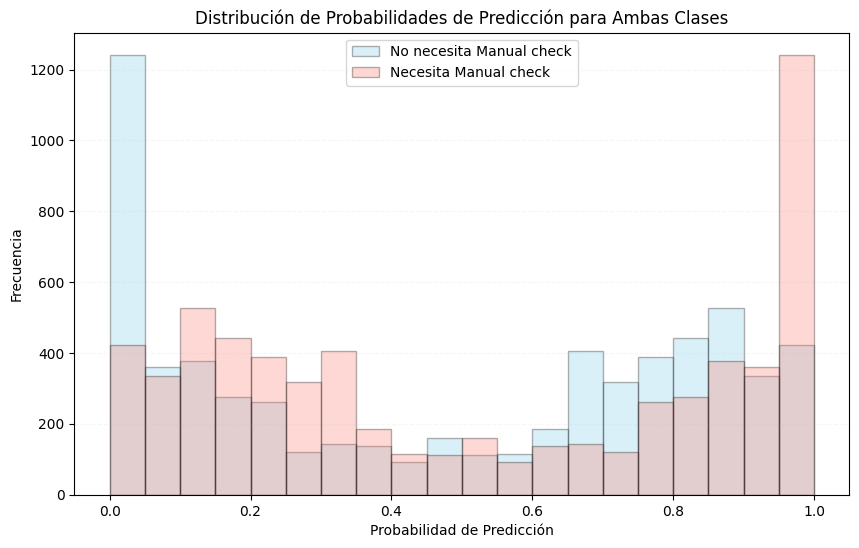

Accuracy: 0.9031001713662564
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.94      0.90      3005
           1       0.94      0.87      0.91      3414

    accuracy                           0.90      6419
   macro avg       0.90      0.91      0.90      6419
weighted avg       0.91      0.90      0.90      6419



Text(70.5815972222222, 0.5, 'Realidad')

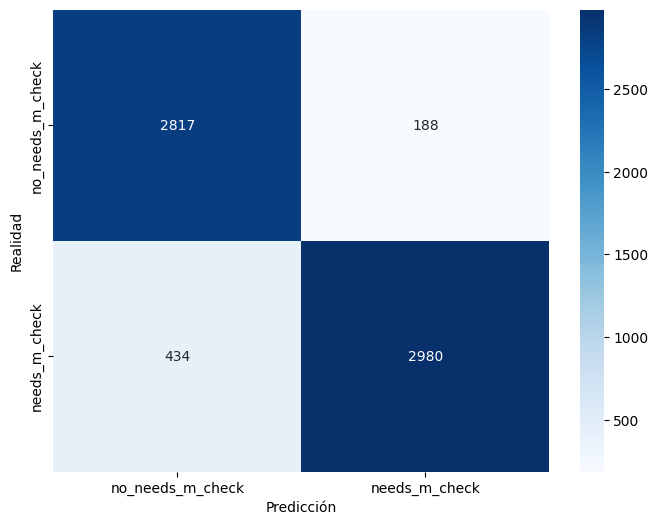

In [74]:
# Pasamos MODELO DE REGRESIÓN LOGISTICA CON TODAS para poder ver después la diferencia al aplicar Ridge y Lasso

# Obtener los nombres de las características
feature_names = X.columns

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

# Crea el clasificador de regresión logística. El 'liblinear' usa metodo de optimización de minimos cuadrados generalizados (L2) y soporta la regularización L1 y L2
clf = LogisticRegression(solver="liblinear")

# Entrena el clasificador
clf.fit(X_train, y_train)

# Realiza predicciones sobre el conjunto de prueba
predicciones = clf.predict(X_test)

# Genera las probabilidades de predicción
predicciones_probabilidades = clf.predict_proba(X_test)

# Muestra las primeras 10 probabilidades de predicción
#predicciones_probabilidades[:10]

# Obtén los coeficientes y asigna los nombres de las características
coeficientes = clf.coef_[0]  # clf.coef_ es un array bidimensional, tomamos la primera fila
feature_coef = list(zip(feature_names, coeficientes))

# Ordena las características por el valor absoluto del coeficiente en orden descendente
feature_coef_sorted = sorted(feature_coef, key=lambda x: abs(x[1]), reverse=True)

# Imprime cada variable junto con su coeficiente ordenado
print("Coeficientes del modelo de regresión logística (ordenados por magnitud):")
for feature, coef in feature_coef_sorted:
    print(f"{feature}: {coef:.8f}")
    
# Convertir coeficientes a multiplicadores de odds
feature_odds = [(feature, np.exp(coef)) for feature, coef in feature_coef_sorted]

# Imprimir los resultados
print("Multiplicadores de odds (elevando e a los coeficientes):")
for feature, odds in feature_odds:
    print(f"{feature}: {odds:.8f}")
    
# Crea un histograma de las probabilidades de predicción para ambas clases
plt.figure(figsize=(10, 6)) 

# # Histograma para la clase negativa (no need manual check)
plt.hist(predicciones_probabilidades[:, 0], bins=20, color="skyblue", edgecolor="black", alpha=0.3, label="No necesita Manual check")
# Histograma para la clase positiva ( need manual check)
plt.hist(predicciones_probabilidades[:, 1], bins=20, color="salmon", edgecolor="black", alpha=0.3, label="Necesita Manual check")
# Título y etiquetas de los ejes
plt.title("Distribución de Probabilidades de Predicción para Ambas Clases")
plt.xlabel("Probabilidad de Predicción")
plt.ylabel("Frecuencia")
plt.legend(loc="upper center") 
# Muestra la leyenda en el gráfico
plt.grid(axis="y", linestyle="--", alpha=0.1)
plt.show()

# Evaluate model performance
print("Accuracy:", clf.score(X_test, y_test))  # Accuracy score
print("Classification Report:\n", classification_report(y_test, predicciones))  # Classification report

# Genera la matriz de confusión
matriz_confusion = confusion_matrix(y_test, predicciones)
columnas = ['no_needs_m_check', 'needs_m_check'] # 0 para No necesita manual check y 1 para Sí necesita manual check

# Visualiza la matriz de confusión utilizando un mapa de calor

plt.figure(figsize=(8, 6))
sns.heatmap(matriz_confusion, annot=True, fmt='d', cmap='Blues', xticklabels=columnas, yticklabels=columnas)
plt.xlabel("Predicción")
plt.ylabel("Realidad")

In [75]:
# Probar modificando el umbral. Cambio a 0.4 (por ejemplo)
umbral = 0.4
predicciones_modificadas = (predicciones_probabilidades[:, 1] >= umbral).astype(int)

Accuracy: 0.9031001713662564
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.91      0.90      3005
           1       0.92      0.91      0.91      3414

    accuracy                           0.91      6419
   macro avg       0.91      0.91      0.91      6419
weighted avg       0.91      0.91      0.91      6419



Text(70.5815972222222, 0.5, 'Realidad')

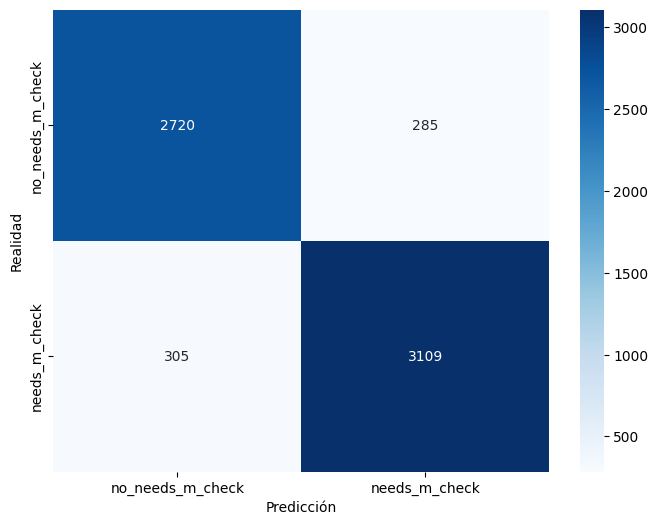

In [76]:
# Evaluate model performance con umbral modificado
print("Accuracy:", clf.score(X_test, y_test))  # Accuracy score
print("Classification Report:\n", classification_report(y_test, predicciones_modificadas))  # Classification report

# Genera la matriz de confusión
matriz_confusion2 = confusion_matrix(y_test, predicciones_modificadas)
columnas = ['no_needs_m_check', 'needs_m_check'] # 0 para No necesita manual check y 1 para Sí necesita manual check

# Visualiza la matriz de confusión utilizando un mapa de calor

plt.figure(figsize=(8, 6))
sns.heatmap(matriz_confusion2, annot=True, fmt='d', cmap='Blues', xticklabels=columnas, yticklabels=columnas)
plt.xlabel("Predicción")
plt.ylabel("Realidad")

In [77]:
# Aplicar Penalizaciones Ridge y Lasso para Regresion Logistica al modelo base 

# Modelo con penalización L1 (similar a Lasso)
logreg_l1 = LogisticRegression(penalty='l1', solver='saga', C=10, random_state=42, max_iter=1000) #probar tb con solver='liblinear'
logreg_l1.fit(X_train, y_train)

# Modelo con penalización L2 (similar a Ridge)
logreg_l2 = LogisticRegression(penalty='l2', solver='lbfgs', C=10, random_state=42, max_iter=1000)
logreg_l2.fit(X_train, y_train)

# Predicciones
y_pred_l1 = logreg_l1.predict(X_test)
y_pred_l2 = logreg_l2.predict(X_test)

# Evaluación (por ejemplo, exactitud)
from sklearn.metrics import accuracy_score
print("Exactitud L1 (LASSO):", accuracy_score(y_test, y_pred_l1))
print("Exactitud L2 (Ridge):", accuracy_score(y_test, y_pred_l2))


Exactitud L1 (LASSO): 0.9188347094563016
Exactitud L2 (Ridge): 0.9129147842343044


In [97]:
# Extraer los coeficientes para la L1
coefs = logreg_l1.coef_  # Para regresión logística binaria, es un vector 1D
feature_coef_l1=list(zip(feature_names, coefs))

# Convertir coeficientes a multiplicadores de odds
feature_odds_l1 = np.exp(coefs_logreg_l1[-1]) 

# Ordena las características por el valor absoluto del multiplicador odd en orden descendente
feature_odds_l1_sorted = list(zip(feature_names, feature_odds_l1))

# Imprimir los resultados
print("Multiplicadores de odds (elevando e a los coeficientes):")
for feature, odds in feature_odds_l1_sorted:
    print(f"{feature}: {odds:.8f}")

# Crear un DataFrame para visualizar los coeficientes junto con las características
importancia = pd.DataFrame({
    'Característica': X_train.columns,
    'Coeficiente': feature_odds_l1
})

# Ordenar por la magnitud de los coeficientes
importancia = importancia.reindex(importancia['Coeficiente'].abs().sort_values(ascending=False).index)

# Mostrar las características con coeficientes no nulos (para Lasso)
importancia_no_nula = importancia[importancia['Coeficiente'] != 0]

print("\nCaracterísticas importantes para LASSO ordenadas por magnitud:")
print(importancia_no_nula)

Multiplicadores de odds (elevando e a los coeficientes):
user_id: 1.93775875
created_at_slot: 0.97608070
created_at_dow: 0.98728420
amount: 11.32488925
n_fees: 0.00000002
n_backs: 0.00017347
n_recovery: 47201134652675892183040.00000000
n_incidents: 137873740523.08303833
n_cr_fe_w: 0.00000094
inflation: 0.25586802
GBP_EUR: 1.02771294
BTC_GBP: 0.09458570
unemploy_rate: 2.32847949
transfer_type_regular: 0.40127917
charge_moment_before: 4.33859598
category_nice: 1.23090066
category_rejected_direct_debit: 47761.68473307

Características importantes para LASSO ordenadas por magnitud:
                    Característica   Coeficiente
6                       n_recovery  4.720113e+22
7                      n_incidents  1.378737e+11
16  category_rejected_direct_debit  4.776168e+04
3                           amount  1.132489e+01
14            charge_moment_before  4.338596e+00
12                   unemploy_rate  2.328479e+00
0                          user_id  1.937759e+00
15                   ca

In [98]:
# Extraer los coeficientes para la L1
coefs2 = logreg_l2.coef_  # Para regresión logística binaria, es un vector 1D
feature_coef_l2=list(zip(feature_names, coefs2))

# Convertir coeficientes a multiplicadores de odds
feature_odds_l2 = np.exp(coefs_logreg_l2[-1]) 

# Ordena las características por el valor absoluto del multiplicador odd en orden descendente
feature_odds_l2_sorted = list(zip(feature_names, feature_odds_l2))

# Imprimir los resultados
print("Multiplicadores de odds (elevando e a los coeficientes):")
for feature, odds in feature_odds_l2_sorted:
    print(f"{feature}: {odds:.8f}")


# Crear un DataFrame para visualizar los coeficientes junto con las características
importancia2 = pd.DataFrame({
    'Característica': X_train.columns,
    'Coeficiente': feature_odds_l2
})

# Ordenar por la magnitud de los coeficientes
importancia2 = importancia2.reindex(importancia2['Coeficiente'].abs().sort_values(ascending=False).index)

# Mostrar las características con coeficientes no nulos (para Lasso)
importancia_no_nula2 = importancia2[importancia2['Coeficiente'] != 0]

print("Características importantes para RIDGE:")
print(importancia_no_nula2)

Multiplicadores de odds (elevando e a los coeficientes):
user_id: 1.93637841
created_at_slot: 0.97310908
created_at_dow: 0.99738178
amount: 11.04068867
n_fees: 0.00000002
n_backs: 0.00017868
n_recovery: 44397284490977696808960.00000000
n_incidents: 142533182850.69482422
n_cr_fe_w: 0.00000098
inflation: 0.26219476
GBP_EUR: 1.04008488
BTC_GBP: 0.09844410
unemploy_rate: 2.28646813
transfer_type_regular: 0.39957220
charge_moment_before: 4.37933943
category_nice: 1.23364815
category_rejected_direct_debit: 24797262.55142342
Características importantes para RIDGE:
                    Característica   Coeficiente
6                       n_recovery  4.439728e+22
7                      n_incidents  1.425332e+11
16  category_rejected_direct_debit  2.479726e+07
3                           amount  1.104069e+01
14            charge_moment_before  4.379339e+00
12                   unemploy_rate  2.286468e+00
0                          user_id  1.936378e+00
15                   category_nice  1.233648

n_fees                            1.971637e-08
n_cr_fe_w                         9.359748e-07
n_backs                           1.734723e-04
BTC_GBP                           9.458570e-02
inflation                         2.558680e-01
transfer_type_regular             4.012792e-01
created_at_slot                   9.760807e-01
created_at_dow                    9.872842e-01
GBP_EUR                           1.027713e+00
category_nice                     1.230901e+00
user_id                           1.937759e+00
unemploy_rate                     2.328479e+00
charge_moment_before              4.338596e+00
amount                            1.132489e+01
category_rejected_direct_debit    4.776168e+04
n_incidents                       1.378737e+11
n_recovery                        4.720113e+22
dtype: float64


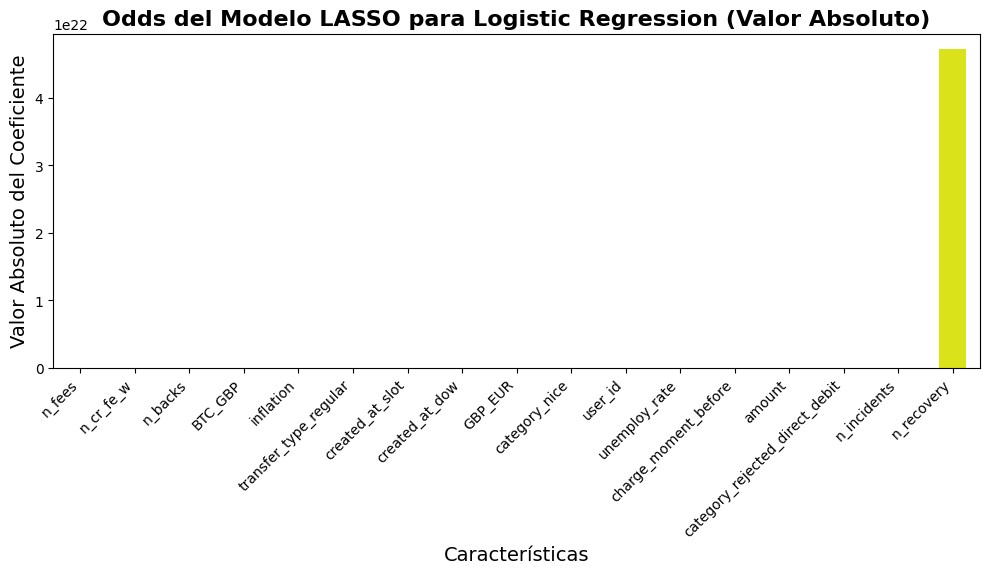

In [103]:
print(coefs_series_l1)

# Aplicar escala logarítmica a los coeficientes
log_coefs_series_l1 = np.log10(np.abs(coefs_series_l1) + 1e-8)  # +1e-8 para evitar log(0)

# Graficamos los coeficientes ordenados por valor absoluto LASSO
plt.figure(figsize=(10, 6))

# Convertir 'coefs' a un pandas.Series
coefs_series_l1 = pd.Series(feature_odds_l1, index=X_train.columns)

# Ordenar los coeficientes de menor a mayor (en valor absoluto)
coefs_series_l1 = coefs_series_l1.abs().sort_values(ascending=True)

# graficar
coefs_series_l1.plot(kind='bar', color=sns.color_palette("viridis", n_colors=len(coefs_series_l1)))

# Añadimos el título y etiquetas a los ejes
plt.title('Odds del Modelo LASSO para Logistic Regression (Valor Absoluto)', fontsize=16, weight='bold')
plt.xlabel('Características', fontsize=14)
plt.ylabel('Valor Absoluto del Coeficiente', fontsize=14)
# Ajustamos las etiquetas del eje x para mejorar la legibilidad
plt.xticks(rotation=45, ha='right')
# Mostramos la gráfica con un diseño ajustado
plt.tight_layout() # Ajuste del espaciado para evitar solapamientos
plt.show()

n_fees                            1.806110e-08
n_cr_fe_w                         9.760787e-07
n_backs                           1.786774e-04
BTC_GBP                           9.844410e-02
inflation                         2.621948e-01
transfer_type_regular             3.995722e-01
created_at_slot                   9.731091e-01
created_at_dow                    9.973818e-01
GBP_EUR                           1.040085e+00
category_nice                     1.233648e+00
user_id                           1.936378e+00
unemploy_rate                     2.286468e+00
charge_moment_before              4.379339e+00
amount                            1.104069e+01
category_rejected_direct_debit    2.479726e+07
n_incidents                       1.425332e+11
n_recovery                        4.439728e+22
dtype: float64


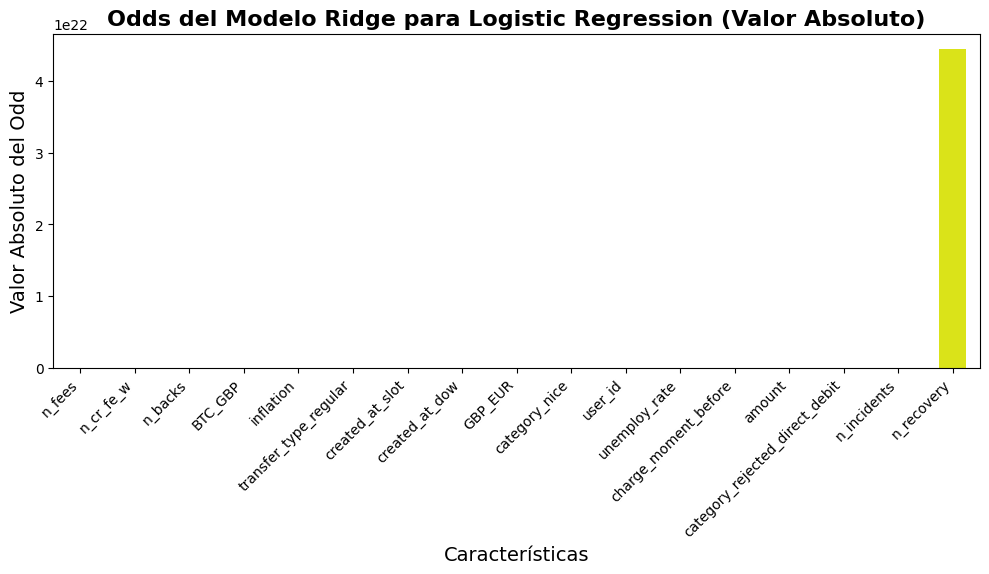

In [ ]:
print(coefs_series_l2)

# Aplicar escala logarítmica a los coeficientes
#log_coefs_series_l2 = np.log10(np.abs(coefs_series_l2) + 1e-8)  # +1e-8 para evitar log(0)

# Graficamos los coeficientes ordenados por valor absoluto RIDGE
plt.figure(figsize=(10, 6))

# Convertir 'coefs' a un pandas.Series
coefs_series_l2 = pd.Series(feature_odds_l2, index=X_train.columns)

# Ordenar los coeficientes de menor a mayor (en valor absoluto)
coefs_series_l2 = coefs_series_l2.abs().sort_values(ascending=True)

# Ordenar los coeficientes de menor a mayor (invirtiendo el orden)
coefs_series_l2.plot(kind='bar', color=sns.color_palette("viridis", n_colors=len(coefs_series_l2)))

# Añadimos el título y etiquetas a los ejes
plt.title('Odds del Modelo Ridge para Logistic Regression (Valor Absoluto)', fontsize=16, weight='bold')
plt.xlabel('Características', fontsize=14)
plt.ylabel('Valor Absoluto del Odd', fontsize=14)
# Ajustamos las etiquetas del eje x para mejorar la legibilidad
plt.xticks(rotation=45, ha='right')
# Mostramos la gráfica con un diseño ajustado
plt.tight_layout() # Ajuste del espaciado para evitar solapamientos
plt.show()

In [109]:
from sklearn.model_selection import cross_val_score
import numpy as np

# Definir valores de C para probar
C_values = np.logspace(-4, 4, 10)
scores_l1 = []
scores_l2 = []

# Iterar manualmente para penalización L1
for C in C_values:
    model_l1 = LogisticRegression(
        C=C, penalty='l1', solver='saga', max_iter=1000, random_state=42
    )
    score = cross_val_score(model_l1, X_train, y_train, cv=5, scoring='accuracy').mean()
    scores_l1.append(score)

# Iterar manualmente para penalización L2
for C in C_values:
    model_l2 = LogisticRegression(
        C=C, penalty='l2', solver='saga', max_iter=1000, random_state=42
    )
    score = cross_val_score(model_l2, X_train, y_train, cv=5, scoring='accuracy').mean()
    scores_l2.append(score)

# Encontrar el mejor C
optimal_C_l1 = C_values[np.argmax(scores_l1)]
optimal_C_l2 = C_values[np.argmax(scores_l2)]

print(f"Mejor valor de C para penalización L1: {optimal_C_l1}")
print(f"Mejor valor de C para penalización L2: {optimal_C_l2}")


Mejor valor de C para penalización L1: 1291.5496650148827
Mejor valor de C para penalización L2: 10000.0


In [ ]:
# Buscamos el C optimo (el alpha optimo) para estas penalizaciones. Validación Cruzada.

# Definir valores de C para probar
C_values = np.logspace(-4, 4, 10)
np.random.seed(seed)
np.random.shuffle(alphas) 

# Modelo con penalización L1
logreg_l1 = LogisticRegressionCV(
    Cs=C_values,  # Valores de C a probar
    cv=5,         # Número de folds para validación cruzada
    penalty='l1',
    solver='saga', # Solver compatible con L1
    max_iter=1000,
    random_state=42
)
logreg_l1.fit(X_train, y_train)

# Modelo con penalización L2
logreg_l2 = LogisticRegressionCV(
    Cs=C_values,  # Valores de C a probar
    cv=5,         # Número de folds para validación cruzada
    penalty='l2',
    solver='saga', # Solver compatible con L2
    max_iter=1000,
    random_state=42
)
logreg_l2.fit(X_train, y_train)

# Encontrar los valores óptimos de C
optimal_C_l1 = logreg_l1.C_[0]
optimal_C_l2 = logreg_l2.C_[0]

print(f"Mejor valor de C para penalización L1: {optimal_C_l1}")
print(f"Mejor valor de C para penalización L2: {optimal_C_l2}")


Mejor valor de C para penalización L1: 1291.5496650148827
Mejor valor de C para penalización L2: 10000.0


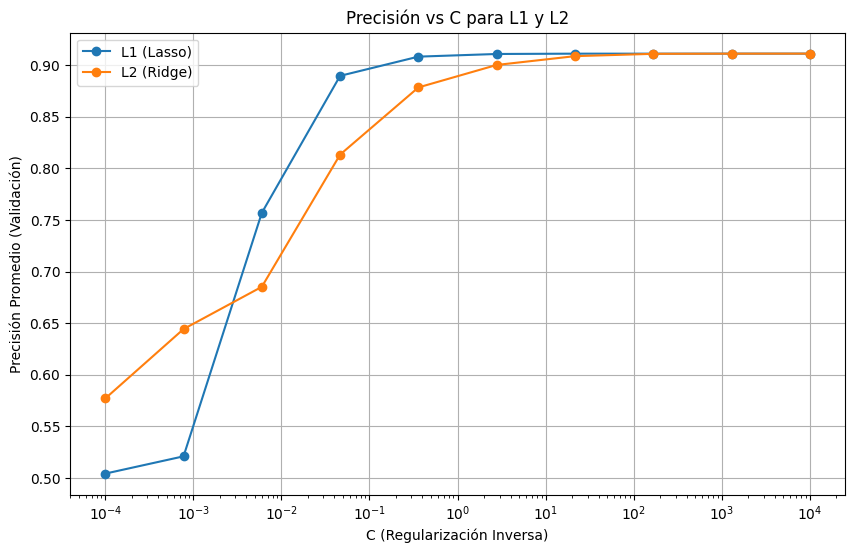

In [108]:
# Graficar precisión promedio para cada C
plt.figure(figsize=(10, 6))
plt.plot(C_values, logreg_l1.scores_[1].mean(axis=0), label='L1 (Lasso)', marker='o')
plt.plot(C_values, logreg_l2.scores_[1].mean(axis=0), label='L2 (Ridge)', marker='o')

plt.xscale('log')  # Escala logarítmica para C
plt.xlabel('C (Regularización Inversa)')
plt.ylabel('Precisión Promedio (Validación)')
plt.title('Precisión vs C para L1 y L2')
plt.legend()
plt.grid(True)
plt.show()

In [84]:
# Ver los puntajes promedio por validación cruzada para cada C
scores_l1 = logreg_l1.scores_[1].mean(axis=0)  # Precisión promedio para cada valor de C
scores_l2 = logreg_l2.scores_[1].mean(axis=0)

# Mostrar C óptimos
print("Puntajes promedio para L1:", scores_l1)
print("Puntajes promedio para L2:", scores_l2)

# Comprobar el índice del mejor puntaje (C óptimo)
optimal_index_l1 = scores_l1.argmax()
optimal_index_l2 = scores_l2.argmax()

print(f"Índice óptimo para L1: {optimal_index_l1}, Mejor C: {logreg_l1.Cs_[optimal_index_l1]}")
print(f"Índice óptimo para L2: {optimal_index_l2}, Mejor C: {logreg_l2.Cs_[optimal_index_l2]}")

Puntajes promedio para L1: [0.50418532 0.52093639 0.75686534 0.88961141 0.90823042 0.91080125
 0.91111286 0.91111286 0.91115181 0.91115181]
Puntajes promedio para L2: [0.57698751 0.64425654 0.68519438 0.813306   0.87839349 0.90016732
 0.90869777 0.91095706 0.91111286 0.91115181]
Índice óptimo para L1: 8, Mejor C: 1291.5496650148827
Índice óptimo para L2: 9, Mejor C: 10000.0


In [85]:
# Probamos MODELO REGRESION LOGISTICA con este analisis 

# Entrenar el modelo final con el valor óptimo de C
logreg_l1_optimal = LogisticRegression(penalty='l1', solver='saga', C=optimal_C_l1, random_state=42, max_iter=1000)
logreg_l2_optimal = LogisticRegression(penalty='l2', solver='saga', C=optimal_C_l2, random_state=42, max_iter=1000)

# Entrenar los modelos con el valor de C óptimo
logreg_l1_optimal.fit(X_train, y_train)
logreg_l2_optimal.fit(X_train, y_train)

LogisticRegression(C=np.float64(10000.0), max_iter=1000, random_state=42,
                   solver='saga')

In [86]:
# Realizar predicciones en el conjunto de prueba
y_pred_l1 = logreg_l1_optimal.predict(X_test)
y_pred_l2 = logreg_l2_optimal.predict(X_test)

# Evaluar el desempeño del modelo L1
print("Evaluación del modelo Lasso (L1):")
print("Precisión:", accuracy_score(y_test, y_pred_l1))
print("Reporte de clasificación L1:\n", classification_report(y_test, y_pred_l1))

# Evaluar el desempeño del modelo L2
print("Evaluación del modelo Ridge (L2):")
print("Precisión:", accuracy_score(y_test, y_pred_l2))
print("Reporte de clasificación L2:\n", classification_report(y_test, y_pred_l2))

Evaluación del modelo Lasso (L1):
Precisión: 0.9188347094563016
Reporte de clasificación L1:
               precision    recall  f1-score   support

           0       0.89      0.94      0.92      3005
           1       0.95      0.90      0.92      3414

    accuracy                           0.92      6419
   macro avg       0.92      0.92      0.92      6419
weighted avg       0.92      0.92      0.92      6419

Evaluación del modelo Ridge (L2):
Precisión: 0.9188347094563016
Reporte de clasificación L2:
               precision    recall  f1-score   support

           0       0.89      0.94      0.92      3005
           1       0.95      0.90      0.92      3414

    accuracy                           0.92      6419
   macro avg       0.92      0.92      0.92      6419
weighted avg       0.92      0.92      0.92      6419



Coeficientes del modelo Ridge (L2) (ordenados por magnitud):
n_recovery: 52.20035051
n_incidents: 25.64911314
n_fees: -17.73962100
n_cr_fe_w: -13.88078733
category_rejected_direct_debit: 10.73239695
n_backs: -8.65922982
amount: 2.42682586
BTC_GBP: -2.35812945
charge_moment_before: 1.46740220
inflation: -1.36304374
transfer_type_regular: -0.91300855
unemploy_rate: 0.84513806
user_id: 0.66153796
category_nice: 0.20768443
GBP_EUR: 0.02733714
created_at_slot: -0.02421586
created_at_dow: -0.01279632

Coeficientes del modelo Lasso (L1) (ordenados por magnitud):
n_recovery: 52.20735809
n_incidents: 25.64938323
n_fees: -17.74130450
n_cr_fe_w: -13.88145619
category_rejected_direct_debit: 10.74321053
n_backs: -8.65942117
amount: 2.42694629
BTC_GBP: -2.35819364
charge_moment_before: 1.46751759
inflation: -1.36307185
transfer_type_regular: -0.91307786
unemploy_rate: 0.84518342
user_id: 0.66152924
category_nice: 0.20772492
GBP_EUR: 0.02733440
created_at_slot: -0.02420610
created_at_dow: -0.01279663

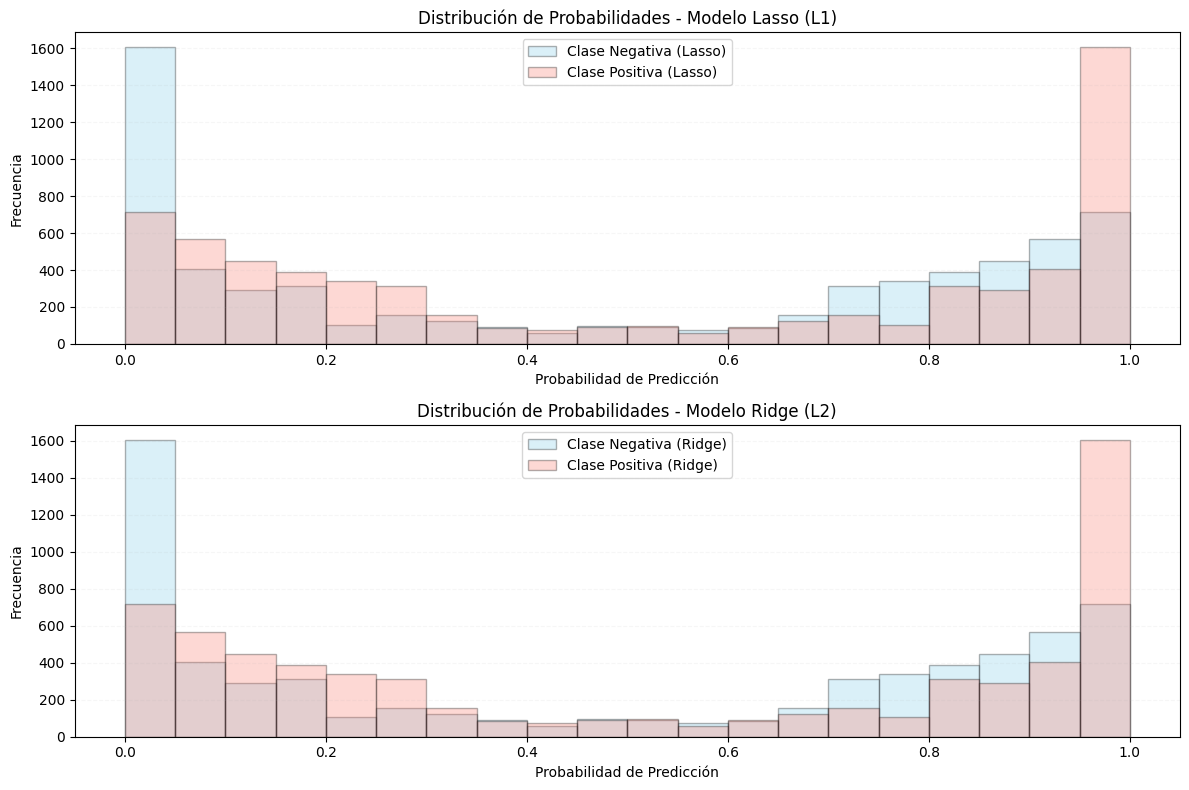

Desempeño del Modelo Lasso (L1):
Accuracy: 0.9188347094563016
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.94      0.92      3005
           1       0.95      0.90      0.92      3414

    accuracy                           0.92      6419
   macro avg       0.92      0.92      0.92      6419
weighted avg       0.92      0.92      0.92      6419


Desempeño del Modelo Ridge (L2):
Accuracy: 0.9188347094563016
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.94      0.92      3005
           1       0.95      0.90      0.92      3414

    accuracy                           0.92      6419
   macro avg       0.92      0.92      0.92      6419
weighted avg       0.92      0.92      0.92      6419



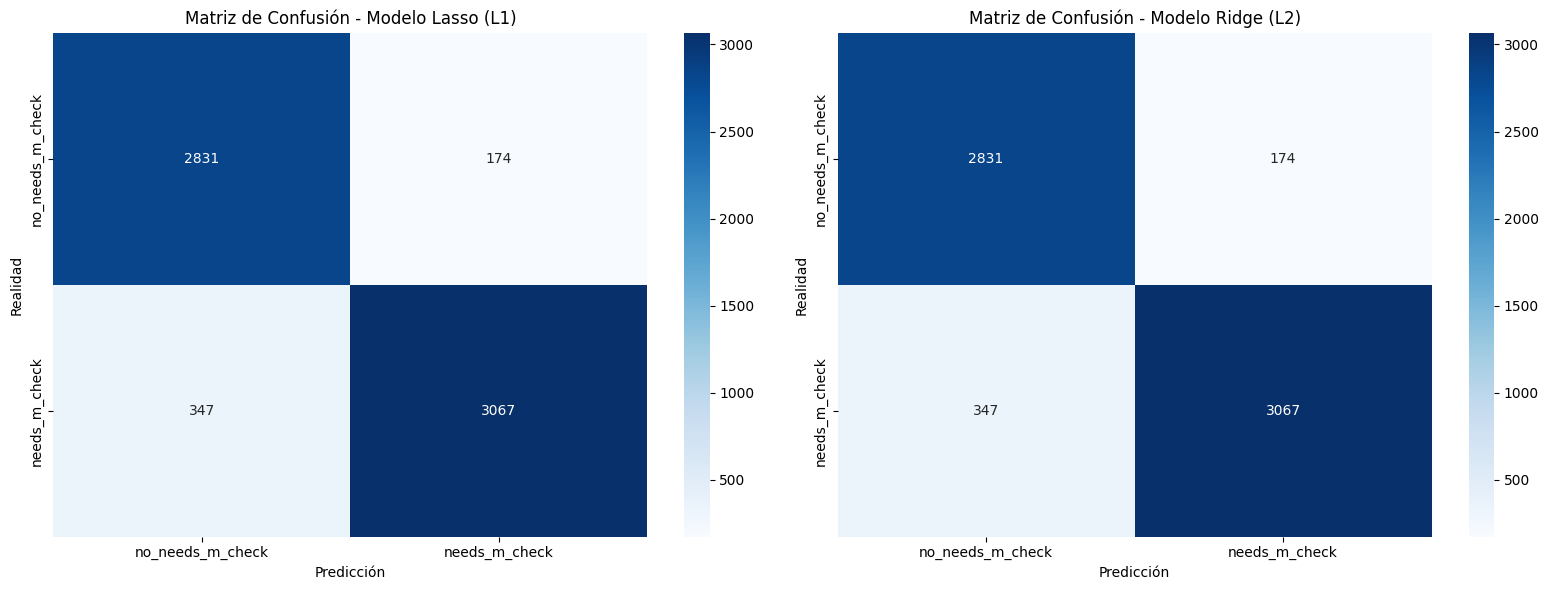

In [87]:
# Genera las probabilidades de predicción para ambos modelos
predicciones_prob_l1 = logreg_l1_optimal.predict_proba(X_test)
predicciones_prob_l2 = logreg_l2_optimal.predict_proba(X_test)

# Obtén los coeficientes de ambos modelos
coef_l1 = logreg_l1_optimal.coef_[0]  # Array unidimensional
coef_l2 = logreg_l2_optimal.coef_[0]

# Asocia los coeficientes con los nombres de las características
feature_coef_l1 = list(zip(feature_names, coef_l1))
feature_coef_l2 = list(zip(feature_names, coef_l2))

# Ordena las características por valor absoluto del coeficiente
feature_coef_l1_sorted = sorted(feature_coef_l1, key=lambda x: abs(x[1]), reverse=True)
feature_coef_l2_sorted = sorted(feature_coef_l2, key=lambda x: abs(x[1]), reverse=True)

# Imprime las características ordenadas por magnitud del coeficiente
print("Coeficientes del modelo Ridge (L2) (ordenados por magnitud):")
for feature, coef in feature_coef_l2_sorted:
    print(f"{feature}: {coef:.8f}")

print("\nCoeficientes del modelo Lasso (L1) (ordenados por magnitud):")
for feature, coef in feature_coef_l1_sorted:
    print(f"{feature}: {coef:.8f}")

# Crea histogramas para ambas clases y modelos
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.hist(predicciones_prob_l1[:, 0], bins=20, color="skyblue", edgecolor="black", alpha=0.3, label="Clase Negativa (Lasso)")
plt.hist(predicciones_prob_l1[:, 1], bins=20, color="salmon", edgecolor="black", alpha=0.3, label="Clase Positiva (Lasso)")
plt.title("Distribución de Probabilidades - Modelo Lasso (L1)")
plt.xlabel("Probabilidad de Predicción")
plt.ylabel("Frecuencia")
plt.legend(loc="upper center")
plt.grid(axis="y", linestyle="--", alpha=0.1)

plt.subplot(2, 1, 2)
plt.hist(predicciones_prob_l2[:, 0], bins=20, color="skyblue", edgecolor="black", alpha=0.3, label="Clase Negativa (Ridge)")
plt.hist(predicciones_prob_l2[:, 1], bins=20, color="salmon", edgecolor="black", alpha=0.3, label="Clase Positiva (Ridge)")
plt.title("Distribución de Probabilidades - Modelo Ridge (L2)")
plt.xlabel("Probabilidad de Predicción")
plt.ylabel("Frecuencia")
plt.legend(loc="upper center")
plt.grid(axis="y", linestyle="--", alpha=0.1)
plt.tight_layout()
plt.show()

# Evaluación de desempeño para ambos modelos

print("Desempeño del Modelo Lasso (L1):")
print("Accuracy:", logreg_l1_optimal.score(X_test, y_test))
print("Classification Report:\n", classification_report(y_test, y_pred_l1))

print("\nDesempeño del Modelo Ridge (L2):")
print("Accuracy:", logreg_l2_optimal.score(X_test, y_test))
print("Classification Report:\n", classification_report(y_test, y_pred_l2))

# Generar matrices de confusión para ambos modelos
matriz_confusion_l1 = confusion_matrix(y_test, y_pred_l1)
matriz_confusion_l2 = confusion_matrix(y_test, y_pred_l2)

# Visualizar matrices de confusión usando mapas de calor
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
sns.heatmap(matriz_confusion_l1, annot=True, fmt='d', cmap='Blues', xticklabels=columnas, yticklabels=columnas)
plt.title("Matriz de Confusión - Modelo Lasso (L1)")
plt.xlabel("Predicción")
plt.ylabel("Realidad")

plt.subplot(1, 2, 2)
sns.heatmap(matriz_confusion_l2, annot=True, fmt='d', cmap='Blues', xticklabels=columnas, yticklabels=columnas)
plt.title("Matriz de Confusión - Modelo Ridge (L2)")
plt.xlabel("Predicción")
plt.ylabel("Realidad")

plt.tight_layout()
plt.show()


In [88]:
# Comparación resultados entre MODELO BASE y el modelo entrenado según LASSO y RIDGE
from sklearn.metrics import roc_auc_score
# ROC-AUC para cada modelo
roc_auc_base = roc_auc_score(y_test, predicciones)
roc_auc_umbral = roc_auc_score(y_test, predicciones_modificadas)
roc_auc_ridge = roc_auc_score(y_test, y_pred_l2)
roc_auc_lasso = roc_auc_score(y_test, y_pred_l1)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Base model
accuracy_base = accuracy_score(y_test, predicciones)
precision_base = precision_score(y_test, predicciones)
recall_base = recall_score(y_test, predicciones)
f1_base = f1_score(y_test, predicciones)
roc_auc_base = roc_auc_score(y_test, predicciones)

# Base model con umbral modificado
accuracy_umbral = accuracy_score(y_test, predicciones_modificadas)
precision_umbral = precision_score(y_test, predicciones_modificadas)
recall_umbral = recall_score(y_test, predicciones_modificadas)
f1_umbral = f1_score(y_test, predicciones_modificadas)
roc_auc_umbral = roc_auc_score(y_test, predicciones_modificadas)

# Ridge model
accuracy_ridge = accuracy_score(y_test, y_pred_l2)
precision_ridge = precision_score(y_test, y_pred_l2)
recall_ridge = recall_score(y_test, y_pred_l2)
f1_ridge = f1_score(y_test, y_pred_l2)
roc_auc_ridge = roc_auc_score(y_test, y_pred_l2)

# Lasso model
accuracy_lasso = accuracy_score(y_test, y_pred_l1)
precision_lasso = precision_score(y_test, y_pred_l1)
recall_lasso = recall_score(y_test, y_pred_l1)
f1_lasso = f1_score(y_test, y_pred_l1)
roc_auc_lasso = roc_auc_score(y_test, y_pred_l1)

# Comparar métricas clave en una tabla

metricas = {
    "Modelo R_LOGISTICA": ["Base", "Umbral 0.4","Ridge", "Lasso"],
    "Accuracy": [accuracy_base, accuracy_umbral ,accuracy_ridge, accuracy_lasso],
    "Precision": [precision_base, precision_umbral,precision_ridge, precision_lasso],
    "Recall": [recall_base, recall_umbral, recall_ridge, recall_lasso],
    "F1-Score": [f1_base, f1_umbral, f1_ridge, f1_lasso],
    "ROC-AUC": [roc_auc_base, roc_auc_umbral, roc_auc_ridge, roc_auc_lasso],
}

df_metricas = pd.DataFrame(metricas)
print(df_metricas)


  Modelo R_LOGISTICA  Accuracy  Precision    Recall  F1-Score   ROC-AUC
0               Base  0.903100   0.940657  0.872876  0.905500  0.905157
1         Umbral 0.4  0.908085   0.916028  0.910662  0.913337  0.907910
2              Ridge  0.918835   0.946313  0.898360  0.921713  0.920228
3              Lasso  0.918835   0.946313  0.898360  0.921713  0.920228


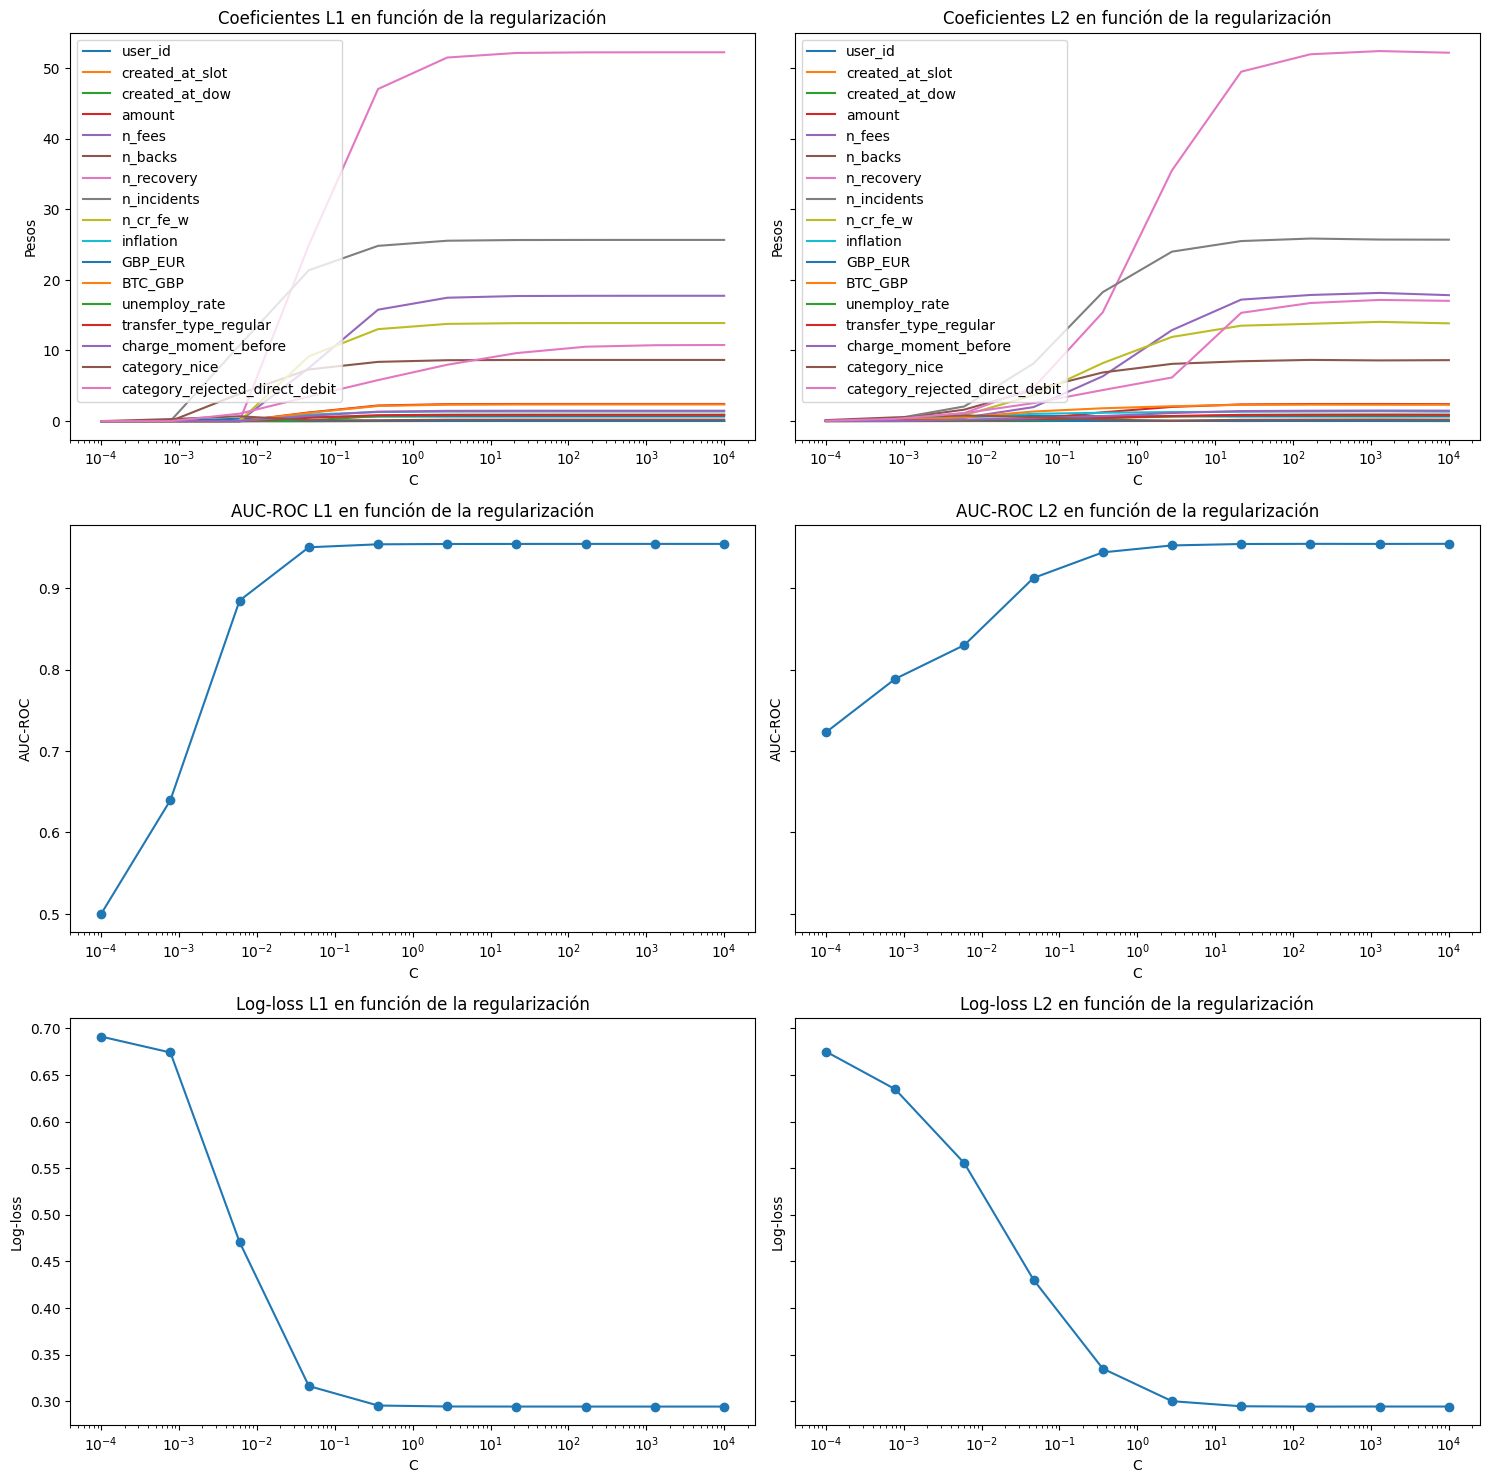

In [89]:
# Graficar el C (que es 1/alpha)

# Valores de C para probar (equivalente a 1/alpha en regresión logística)
C_values = np.logspace(-4, 4, 10)

# Inicialización de listas para almacenar resultados
coefs_logreg_l1 = []
coefs_logreg_l2 = []
auc_l1 = []
auc_l2 = []
logloss_l1 = []
logloss_l2 = []

# Modelos y evaluación
for C in C_values:
    # Penalización L1
    logreg_l1 = LogisticRegression(penalty='l1', C=C, solver='saga', max_iter=1000, random_state=42)
    logreg_l1.fit(X_train, y_train)
    coefs_logreg_l1.append(logreg_l1.coef_[0])  # Guardar coeficientes
    y_pred_prob_l1 = logreg_l1.predict_proba(X_test)[:, 1]  # Probabilidades para ROC y log-loss
    auc_l1.append(roc_auc_score(y_test, y_pred_prob_l1))  # AUC-ROC
    logloss_l1.append(log_loss(y_test, y_pred_prob_l1))  # Log-loss

    # Penalización L2
    logreg_l2 = LogisticRegression(penalty='l2', C=C, solver='lbfgs', max_iter=1000, random_state=42)
    logreg_l2.fit(X_train, y_train)
    coefs_logreg_l2.append(logreg_l2.coef_[0])  # Guardar coeficientes
    y_pred_prob_l2 = logreg_l2.predict_proba(X_test)[:, 1]
    auc_l2.append(roc_auc_score(y_test, y_pred_prob_l2))  # AUC-ROC
    logloss_l2.append(log_loss(y_test, y_pred_prob_l2))  # Log-loss

# Configuración del gráfico
fig, axs = plt.subplots(3, 2, figsize=(15, 15), sharey='row')

# Coeficientes L1
for coef in np.abs(coefs_logreg_l1).T:
    axs[0, 0].plot(C_values, coef)
axs[0, 0].set_xscale('log')
axs[0, 0].set_title('Coeficientes L1 en función de la regularización')
axs[0, 0].set_xlabel('C')
axs[0, 0].set_ylabel('Pesos')
axs[0, 0].legend(feature_names)

# Coeficientes L2
for coef in np.abs(coefs_logreg_l2).T:
    axs[0, 1].plot(C_values, coef)
axs[0, 1].set_xscale('log')
axs[0, 1].set_title('Coeficientes L2 en función de la regularización')
axs[0, 1].set_xlabel('C')
axs[0, 1].set_ylabel('Pesos')
axs[0, 1].legend(feature_names)

# AUC-ROC L1
axs[1, 0].plot(C_values, auc_l1, marker='o')
axs[1, 0].set_xscale('log')
axs[1, 0].set_title('AUC-ROC L1 en función de la regularización')
axs[1, 0].set_xlabel('C')
axs[1, 0].set_ylabel('AUC-ROC')

# AUC-ROC L2
axs[1, 1].plot(C_values, auc_l2, marker='o')
axs[1, 1].set_xscale('log')
axs[1, 1].set_title('AUC-ROC L2 en función de la regularización')
axs[1, 1].set_xlabel('C')
axs[1, 1].set_ylabel('AUC-ROC')

# Log-loss L1
axs[2, 0].plot(C_values, logloss_l1, marker='o')
axs[2, 0].set_xscale('log')
axs[2, 0].set_title('Log-loss L1 en función de la regularización')
axs[2, 0].set_xlabel('C')
axs[2, 0].set_ylabel('Log-loss')

# Log-loss L2
axs[2, 1].plot(C_values, logloss_l2, marker='o')
axs[2, 1].set_xscale('log')
axs[2, 1].set_title('Log-loss L2 en función de la regularización')
axs[2, 1].set_xlabel('C')
axs[2, 1].set_ylabel('Log-loss')

plt.tight_layout()
plt.show()


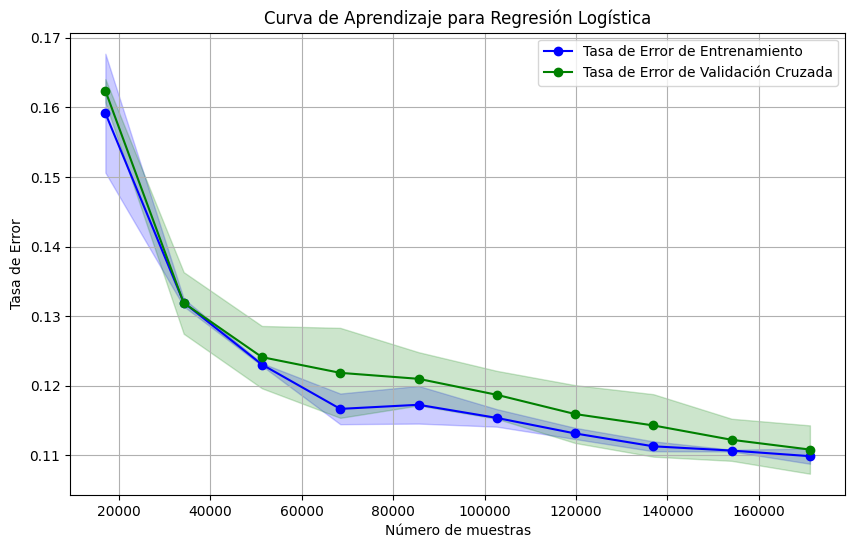

In [90]:
# Curvas de aprendizaje

# Calcular la curva de aprendizaje para modelo BASE
train_sizes, train_scores, test_scores = learning_curve(
    clf , X_train, y_train, cv=3, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10), random_state=42
)

# Calcular la media y desviación estándar de las puntuaciones de entrenamiento y validación
train_mean = np.mean(train_scores, axis=1)  # Media de las puntuaciones de entrenamiento
train_std = np.std(train_scores, axis=1)    # Desviación estándar de las puntuaciones de entrenamiento
test_mean = np.mean(test_scores, axis=1)   # Media de las puntuaciones de validación
test_std = np.std(test_scores, axis=1)     # Desviación estándar de las puntuaciones de validación

# Conversión a tasa de error (1 - precisión)
train_error = 1 - train_mean
test_error = 1 - test_mean

# 5. Graficar la curva de aprendizaje
plt.figure(figsize=(10, 6))  # Definir tamaño de la figura
plt.plot(train_sizes * 10, train_error, 'o-', color="blue", label="Tasa de Error de Entrenamiento")  # Tasa de error en entrenamiento
plt.plot(train_sizes * 10, test_error, 'o-', color="green", label="Tasa de Error de Validación Cruzada")  # Tasa de error en validación cruzada
plt.fill_between(
    train_sizes * 10, 
    train_error - train_std, 
    train_error + train_std, 
    color="blue", 
    alpha=0.2  # Área sombreada alrededor de la tasa de error de entrenamiento
)
plt.fill_between(
    train_sizes * 10, 
    test_error - test_std, 
    test_error + test_std, 
    color="green", 
    alpha=0.2  # Área sombreada alrededor de la tasa de error de validación cruzada
)

plt.title("Curva de Aprendizaje para Regresión Logística")  # Título del gráfico
plt.xlabel("Número de muestras")  # Etiqueta del eje x
plt.ylabel("Tasa de Error")  # Etiqueta del eje y
plt.legend(loc="best")  # Leyenda de la gráfica
plt.grid(True)  # Mostrar cuadrícula
plt.show()  # Mostrar gráfica

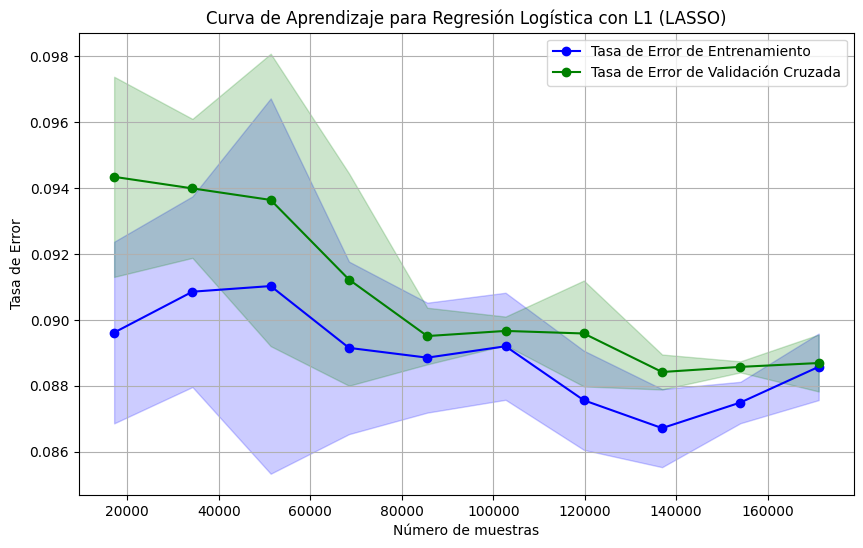

In [91]:
# Calcular la curva de aprendizaje para LASSO
train_sizes, train_scores, test_scores = learning_curve(
    logreg_l1_optimal , X_train, y_train, cv=3, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10), random_state=42
)

# Calcular la media y desviación estándar de las puntuaciones de entrenamiento y validación
train_mean = np.mean(train_scores, axis=1)  # Media de las puntuaciones de entrenamiento
train_std = np.std(train_scores, axis=1)    # Desviación estándar de las puntuaciones de entrenamiento
test_mean = np.mean(test_scores, axis=1)   # Media de las puntuaciones de validación
test_std = np.std(test_scores, axis=1)     # Desviación estándar de las puntuaciones de validación

# Conversión a tasa de error (1 - precisión)
train_error = 1 - train_mean
test_error = 1 - test_mean

# 5. Graficar la curva de aprendizaje
plt.figure(figsize=(10, 6))  # Definir tamaño de la figura
plt.plot(train_sizes * 10, train_error, 'o-', color="blue", label="Tasa de Error de Entrenamiento")  # Tasa de error en entrenamiento
plt.plot(train_sizes * 10, test_error, 'o-', color="green", label="Tasa de Error de Validación Cruzada")  # Tasa de error en validación cruzada
plt.fill_between(
    train_sizes * 10, 
    train_error - train_std, 
    train_error + train_std, 
    color="blue", 
    alpha=0.2  # Área sombreada alrededor de la tasa de error de entrenamiento
)
plt.fill_between(
    train_sizes * 10, 
    test_error - test_std, 
    test_error + test_std, 
    color="green", 
    alpha=0.2  # Área sombreada alrededor de la tasa de error de validación cruzada
)

plt.title("Curva de Aprendizaje para Regresión Logística con L1 (LASSO)")  # Título del gráfico
plt.xlabel("Número de muestras")  # Etiqueta del eje x
plt.ylabel("Tasa de Error")  # Etiqueta del eje y
plt.legend(loc="best")  # Leyenda de la gráfica
plt.grid(True)  # Mostrar cuadrícula
plt.show()  # Mostrar gráfica

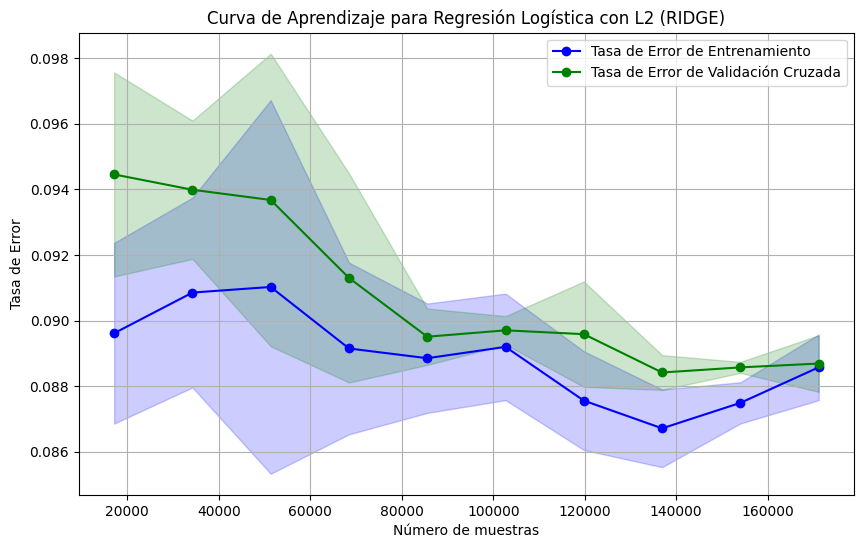

In [92]:
# Calcular la curva de aprendizaje para RIDGE
train_sizes, train_scores, test_scores = learning_curve(
    logreg_l2_optimal , X_train, y_train, cv=3, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10), random_state=42
)

# Calcular la media y desviación estándar de las puntuaciones de entrenamiento y validación
train_mean = np.mean(train_scores, axis=1)  # Media de las puntuaciones de entrenamiento
train_std = np.std(train_scores, axis=1)    # Desviación estándar de las puntuaciones de entrenamiento
test_mean = np.mean(test_scores, axis=1)   # Media de las puntuaciones de validación
test_std = np.std(test_scores, axis=1)     # Desviación estándar de las puntuaciones de validación

# Conversión a tasa de error (1 - precisión)
train_error = 1 - train_mean
test_error = 1 - test_mean

# 5. Graficar la curva de aprendizaje
plt.figure(figsize=(10, 6))  # Definir tamaño de la figura
plt.plot(train_sizes * 10, train_error, 'o-', color="blue", label="Tasa de Error de Entrenamiento")  # Tasa de error en entrenamiento
plt.plot(train_sizes * 10, test_error, 'o-', color="green", label="Tasa de Error de Validación Cruzada")  # Tasa de error en validación cruzada
plt.fill_between(
    train_sizes * 10, 
    train_error - train_std, 
    train_error + train_std, 
    color="blue", 
    alpha=0.2  # Área sombreada alrededor de la tasa de error de entrenamiento
)
plt.fill_between(
    train_sizes * 10, 
    test_error - test_std, 
    test_error + test_std, 
    color="green", 
    alpha=0.2  # Área sombreada alrededor de la tasa de error de validación cruzada
)

plt.title("Curva de Aprendizaje para Regresión Logística con L2 (RIDGE)")  # Título del gráfico
plt.xlabel("Número de muestras")  # Etiqueta del eje x
plt.ylabel("Tasa de Error")  # Etiqueta del eje y
plt.legend(loc="best")  # Leyenda de la gráfica
plt.grid(True)  # Mostrar cuadrícula
plt.show()  # Mostrar gráfica